<a href="https://colab.research.google.com/github/AlliBusa/denoising-self-study/blob/main/test_trial_deep_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries 

import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import os
import cv2

# %tensorflow_version 2.x
import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
# from tensorflow.keras.callbacks import TensorBoard
# from tensorflow.keras.optimizers import Adam

# for 
import PIL

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
# # import data 
# dataType = ['test', 'train', 'val']
# imgType = ['noisy', 'original']

# combinedList = [f"{d}_{i}" for d in dataType for i in imgType]

# print(combinedList)

In [ ]:
data_dir = './BSDS500'
Xtrain = np.load(os.path.join(data_dir, 'train_noisy_array.npy'))
ytrain = np.load(os.path.join(data_dir, 'train_original_array.npy'))

Xtest = np.load(os.path.join(data_dir, 'test_noisy_array.npy'))
ytest = np.load(os.path.join(data_dir, 'test_original_array.npy'))

Xval = np.load(os.path.join(data_dir, 'val_noisy_array.npy'))
yval = np.load(os.path.join(data_dir, 'val_original_array.npy'))

In [ ]:
# class DataGenerator(Sequence):
#     def __init__(self, x_set, y_set, batch_size):
#         self.x, self.y = x_set, y_set
#         self.batch_size = batch_size

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y

# train_gen = DataGenerator(Xtrain[1:300,:], ytrain[1:300,:], 32)
# val_gen = DataGenerator(Xval[1:300,:], yval[1:300,:], 32)

# Create Model 

In [ ]:
alpha = 0.5
row = 180
col = 180
numchannels = 1

# Define the inputs

input_img = tf.keras.Input(shape=(row,col, numchannels))
x =input_img
y = input_img

# Define the layers of the model
num_iterations = 4
num_CNN_layers = 3
for i in range(num_iterations):
    x_k = x
    # print(x_k)
    # First layer of CNN that reshapes x
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, numchannels))(x)
    for j in range(num_CNN_layers-2):
        # expand input into cnn
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(numchannels, (3, 3), activation='relu', padding='same')(x)
    # print(x.shape)
        # x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # implemnt (αky + xk + xk+1/2)/(αk + 1).
    denom = 1/(1+alpha)
    alpha_y = tf.multiply(alpha, y)
    # tf.print("x_k:", x_k)
    # print(x_k)
    # print(x)
    x_and_x_k = tf.add(x_k, x)
    x_and_y = tf.add(x_and_x_k, alpha_y)
    x = tf.multiply(denom, x_and_y)
    x = tf.keras.layers.Activation('relu')(x)
    # x = tf.multiply(tf.add(tf.add(tf.multiply(alpha, y), x_k), x), denom)


outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(x)#tf.keras.layers.Dense(10, activation='softmax')(x)

# Define the model
model = tf.keras.Model(inputs=input_img, outputs=outputs)

# Print the model summary
model.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='conv2d_9/Relu:0', description="created by layer 'conv2d_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='tf.math.multiply_1/Mul:0', description="created by layer 'tf.math.multiply_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='conv2d_19/Relu:0', description="created by layer 'conv2d_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='tf.math.multiply_3/Mul:0', description="created by layer 'tf.math.multiply_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='conv2d_29/Relu:0', description="created by layer 'conv2d_29'")
KerasTensor(type_spe

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
checkpoint_path = "./BSDS500/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

os.listdir(checkpoint_dir) 

['data',
 'test_noisy_array.npy',
 'test_original_array.npy',
 'train_noisy_array.npy',
 'train_original_array.npy',
 'val_original_array.npy',
 'val_noisy_array.npy']

In [ ]:
# history = model.fit(train_gen,validation_data = val_gen,
#                     epochs=4,
#                     callbacks=[cp_callback])

history = model.fit(Xtrain[1:300,:], ytrain[1:300,:], validation_data=(Xval[1:300,:], yval[1:300,:]),
                    epochs=4,
                    callbacks=[cp_callback])

Epoch 1/4
10/10 [==============================] - ETA: 0s - loss: 4456.0796  
Epoch 1: saving model to ./BSDS500/cp.ckpt
10/10 [==============================] - 2417s 241s/step - loss: 4456.0796 - val_loss: 3770.6589
Epoch 2/4
10/10 [==============================] - ETA: 0s - loss: 4455.0088  
Epoch 2: saving model to ./BSDS500/cp.ckpt
10/10 [==============================] - 2329s 234s/step - loss: 4455.0088 - val_loss: 3770.6589
Epoch 3/4
10/10 [==============================] - ETA: 0s - loss: 4455.0093  
Epoch 3: saving model to ./BSDS500/cp.ckpt
10/10 [==============================] - 2286s 229s/step - loss: 4455.0093 - val_loss: 3770.6589
Epoch 4/4
 1/10 [==>...........................] - ETA: 32:35 - loss: 3577.0200

In [ ]:
model.load_weights('./BSDS500/cp.ckpt')

In [ ]:
y_pred = model.predict(Xtest[1:50,], batch_size = 10)
#plt.imshow(x_test[0,:,:,0]+y_pred[0,:,:,0]-0.5, cmap='gray')

# plt.imshow(y_pred[0,:,:,0], cmap='gray')

5/5 [==============================] - 98s 20s/step


In [ ]:
np.shape(y_pred)

(49, 180, 180, 1)

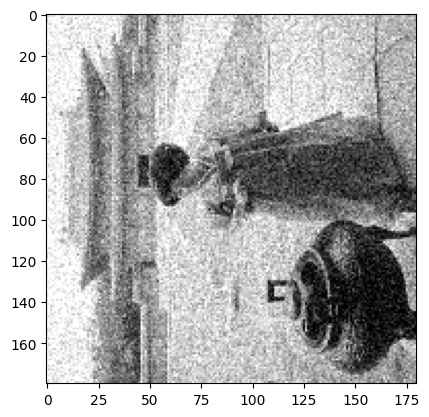

In [ ]:
plt.imshow(Xtest[1,:,:], cmap='gray')

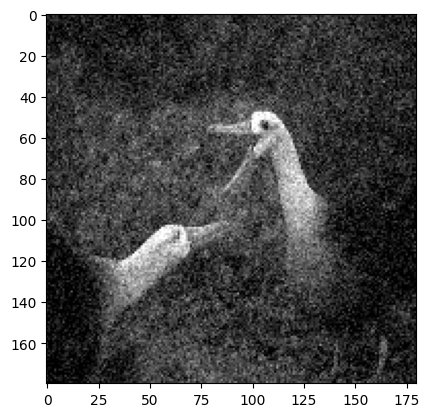

In [ ]:
plt.imshow(y_pred[0,:,:,0], cmap='gray')

In [ ]:
y_predT = model.predict(Xtest[1:2,], batch_size=1)


1/1 [==============================] - 2s 2s/step


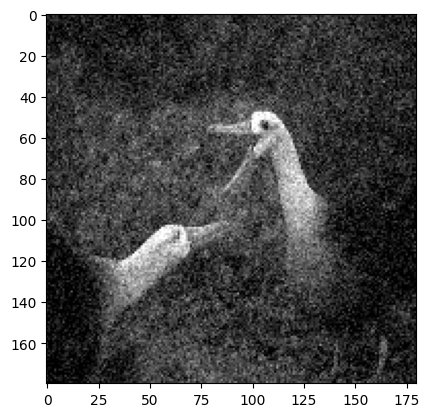

In [ ]:
plt.imshow(y_predT[0,:,:,0], cmap='gray')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

In [ ]:
def evaluateImage(original_image, Xtest, y_pred):
  print(f'PSNR for x : {peak_signal_noise_ratio(ytest[1,], Xtest[1,],data_range=original_image.max() - original_image.min())}')
  print(f'PSNR for ypred : {peak_signal_noise_ratio(ytest[1,], y_pred[0,:,:,0],data_range=original_image.max() - original_image.min())}')
  plt.figure()
  plt.imshow(y_predT[0,:,:,0], cmap='gray')
  plt.figure()
  plt.imshow(Xtest[1,:,:], cmap='gray')

In [ ]:
original_image = ytest[1,]
peak_signal_noise_ratio(ytest[1,], Xtest[1,],data_range=original_image.max() - original_image.min())

20.726944679384182

In [ ]:
peak_signal_noise_ratio(ytest[1,], y_predT[0,:,:,0],data_range=original_image.max() - original_image.min())

20.726944679384182

In [ ]:
np.shape(ytest[1,])

(180, 180)

In [ ]:
np.min(ytest[1,])

1.0

In [ ]:
np.max(ytest[1,])

255.0

In [ ]:
alpha = 0.5
row = 180
col = 180
numchannels = 1

# Define the inputs

input_img = tf.keras.Input(shape=(row,col, numchannels))
x =input_img
y = input_img

# Define the layers of the model
num_iterations = 4
num_CNN_layers = 3
for i in range(num_iterations):
    x_k = x
    # print(x_k)
    # First layer of CNN that reshapes x
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, numchannels))(x)
    for j in range(num_CNN_layers-2):
        # expand input into cnn
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(numchannels, (3, 3), activation='relu', padding='same')(x)
    # print(x.shape)
        # x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # implemnt (αky + xk + xk+1/2)/(αk + 1).
    denom = 1/(1+alpha)
    alpha_y = tf.multiply(alpha, y)
    # tf.print("x_k:", x_k)
    print(x_k)
    print(x)
    x_and_x_k = tf.add(x_k, x)
    x_and_y = tf.add(x_and_x_k, alpha_y)
    x = tf.multiply(denom, x_and_y)
    # x = tf.multiply(tf.add(tf.add(tf.multiply(alpha, y), x_k), x), denom)


outputs = x#tf.keras.layers.Dense(10, activation='softmax')(x)

# Define the model
modelSimple = tf.keras.Model(inputs=input_img, outputs=outputs)

# Print the model summary
modelSimple.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='conv2d_79/Relu:0', description="created by layer 'conv2d_79'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='tf.math.multiply_9/Mul:0', description="created by layer 'tf.math.multiply_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='conv2d_82/Relu:0', description="created by layer 'conv2d_82'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='tf.math.multiply_11/Mul:0', description="created by layer 'tf.math.multiply_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 1), dtype=tf.float32, name=None), name='conv2d_85/Relu:0', description="created by layer 'conv2d_85'")
KerasTensor(type

In [ ]:
modelSimple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
checkpoint_path = "./BSDS500/cpSimple.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

os.listdir(checkpoint_dir) 

['data',
 'test_noisy_array.npy',
 'test_original_array.npy',
 'train_noisy_array.npy',
 'train_original_array.npy',
 'val_original_array.npy',
 'val_noisy_array.npy',
 'cp.ckpt.index',
 'cp.ckpt.data-00000-of-00001',
 'checkpoint']

In [ ]:
# history = model.fit(train_gen,validation_data = val_gen,
#                     epochs=4,
#                     callbacks=[cp_callback])

historySimple = modelSimple.fit(Xtrain[1:100,:], ytrain[1:100,:], validation_data=(Xval[1:100,:], yval[1:100,:]),
                    epochs=2)

Epoch 1/2
4/4 [==============================] - 172s 41s/step - loss: 4859.5171 - val_loss: 3622.6973
Epoch 2/2
4/4 [==============================] - 177s 44s/step - loss: 4523.3359 - val_loss: 3622.6982


In [ ]:
y_pred = modelSimple.predict(Xtest[1:2,], batch_size=1)


1/1 [==============================] - 0s 393ms/step


PSNR for x : 20.726944679384182
PSNR for ypred : 20.726945570429244


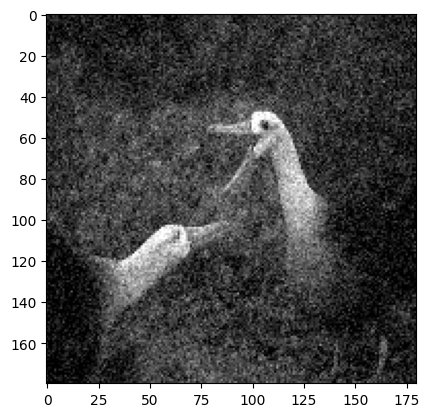

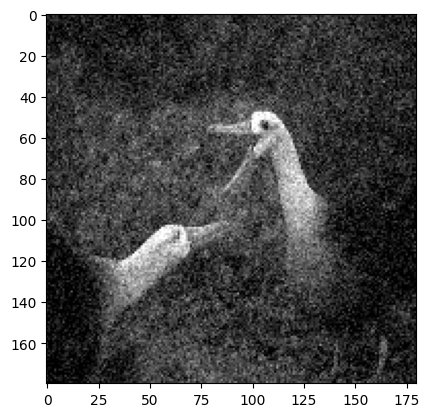

In [ ]:
evaluateImage(original_image, Xtest, y_pred)

In [ ]:
alpha = 0.5
row = 180
col = 180
numchannels = 1

# Define the inputs

input_img = tf.keras.Input(shape=(row,col, numchannels))
x =input_img
y = input_img

# Define the layers of the model
num_iterations = 4
num_CNN_layers = 3
for i in range(num_iterations):
    x_k = x
    # print(x_k)
    # First layer of CNN that reshapes x
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, numchannels))(x)
    for j in range(num_CNN_layers-2):
        # expand input into cnn
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(numchannels, (3, 3), activation='relu', padding='same')(x)
    # # print(x.shape)
    #     # x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # # implemnt (αky + xk + xk+1/2)/(αk + 1).
    # denom = 1/(1+alpha)
    # alpha_y = tf.multiply(alpha, y)
    # # tf.print("x_k:", x_k)
    # print(x_k)
    # print(x)
    # x_and_x_k = tf.add(x_k, x)
    # x_and_y = tf.add(x_and_x_k, alpha_y)
    # x = tf.multiply(denom, x_and_y)
    # # x = tf.multiply(tf.add(tf.add(tf.multiply(alpha, y), x_k), x), denom)


outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(x)#tf.keras.layers.Dense(10, activation='softmax')(x)

# Define the model
modelSimple = tf.keras.Model(inputs=input_img, outputs=outputs)

# Print the model summary
modelSimple.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d_64 (Conv2D)          (None, 180, 180, 64)      640       
                                                                 
 conv2d_65 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 conv2d_66 (Conv2D)          (None, 180, 180, 1)       577       
                                                                 
 conv2d_67 (Conv2D)          (None, 180, 180, 64)      640       
                                                                 
 conv2d_68 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 conv2d_69 (Conv2D)          (None, 180, 180, 1)       577 

In [ ]:
modelSimple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# history = model.fit(train_gen,validation_data = val_gen,
#                     epochs=4,
#                     callbacks=[cp_callback])

historySimple = modelSimple.fit(Xtrain[1:100,:], ytrain[1:100,:], validation_data=(Xval[1:100,:], yval[1:100,:]),
                    epochs=2)

y_pred = modelSimple.predict(Xtest[1:2,], batch_size=1)


Epoch 1/2
4/4 [==============================] - 176s 42s/step - loss: 14161.8418 - val_loss: 15124.1309
Epoch 2/2
1/1 [==============================] - 0s 399ms/step


PSNR for x : 20.726944679384182
PSNR for ypred : 11.333697529007678


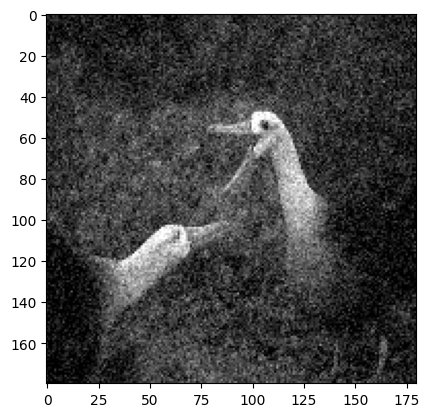

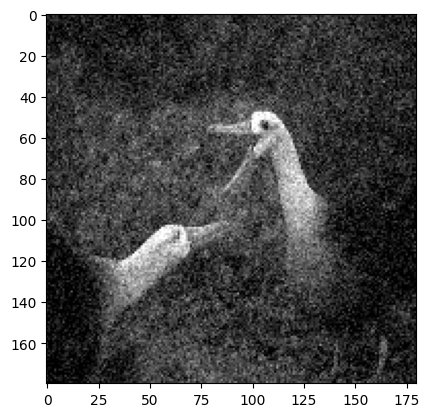

In [ ]:
evaluateImage(original_image, Xtest, y_pred)